In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l
import collections
import re
import random

d2l.gpu_mem_init()

2025-09-29 10:17:30.364107: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-29 10:17:30.427577: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-29 10:17:31.922272: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [3]:
def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return tf.random.normal(shape=shape, mean=0.0, stddev=0.1, dtype=tf.float32)
    def tree():
        return (
            tf.Variable(normal((num_inputs, num_hiddens)), dtype=tf.float32),
            tf.Variable(normal((num_hiddens, num_hiddens)), dtype=tf.float32),
            tf.Variable(tf.zeros(num_hiddens), dtype=tf.float32)
        )
    
    w_xr, w_hr, b_r = tree()
    w_xz, w_hz, b_z = tree()
    w_xh, w_hh, b_h = tree()

    w_hq = tf.Variable(normal((num_hiddens, num_outputs)), dtype=tf.float32)
    b_q = tf.Variable(tf.zeros(num_outputs), dtype=tf.float32)

    params = [w_xz, w_hz, b_z, w_xr, w_hr, b_r, w_xh, w_hh, b_h, w_hq, b_q]
    return params

In [4]:
def init_gru_state(batch_size, num_hiddens):
    return (tf.zeros((batch_size, num_hiddens)),)

In [5]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        X = tf.reshape(X, [-1, W_xz.shape[0]])
        Z = tf.sigmoid(tf.matmul(X, W_xz) + tf.matmul(H, W_hz) + b_z)
        R = tf.sigmoid(tf.matmul(X, W_xr) + tf.matmul(H, W_hr) + b_r)
        H_candidate = tf.tanh(tf.matmul(X, W_xh) + tf.matmul(R * H, W_hh) + b_h)
        H = Z * H + (1 - Z) * H_candidate
        Y = tf.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return (tf.concat(outputs, axis=0)),(H,)

困惑度 1.0, 552.7 词元/秒 /GPU:0
time traveller for so it will be convenient to speak of himwas ex
traveller with a slight accession ofcheerfulness really this


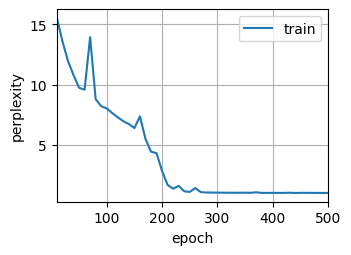

In [6]:
vocab_size, num_hiddens, device_name = len(vocab), 256, d2l.try_gpu()._device_name
# 定义训练策略
strategy = tf.distribute.OneDeviceStrategy(device_name)
num_epochs, lr = 500, 1.0
with strategy.scope():
    model = d2l.RNNModelScratch(len(vocab), num_hiddens, init_gru_state, gru, get_params)

d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, strategy)